# 2 Data Wrangling

## Table of Contents:

* [2.1 Introduction](#2.1_Introduction)
* [2.2 Import Packages](#2.2_Import_Packages)
* [2.3 Load the Accelerometer Data](#2.3_Load_the_Accelerometer_Data)
* [2.4 Load the TAC Data](#2.4_Load_the_TAC_Data)
* [2.5 Exploring the Data](#2.5_Exploring_the_Data)
  * [2.5.1 Combining Accelerometer and TAC data](#2.5.1_Combining_Accelerometer_and_TAC_data)
  * [2.5.2 Smoothing the raw TAC data](#2.5.2_Smoothing_the_raw_TAC_data)
    * [2.5.2.1 Rolling Average](#2.5.2.1_Rolling_Average)
    * [2.5.2.2 Interpolation](#2.5.2.2_Interpolation)
* [2.6 Summary and Next Steps](#2.6_Summary_and_Next_Steps)

## 2.1 Introduction<a id='2.1_Introduction'></a>

__Purpose__: The purpose of this project is to use mobile phone accelerometer data to detect episodes of heavy drinking, i.e. when Blood Alcohol Concentration (BAC) > 8% for an individual. This detection method would be helpful and potentially life-saving when interventions are needed.

This data set from the UCI Machine Learning Repository contains data on 13 anonymized participants, each with 2 sets of data: Accelerometer data and TAC data. Transdermal Alcohol Concentration (TAC) was collected using SCRAM ankle bracelets, which functions like a breathalyzer for the ankle. The TAC data tells us when the participant was drunk (BAC > 8%). We can use this information in conjunction with the smartphone accelerometer data to teach a machine learning algorithm to classify when someone is or isn’t drunk. 

http://archive.ics.uci.edu/ml/datasets/Bar+Crawl%3A+Detecting+Heavy+Drinking

__Objective__: Clean the dataset and address issues like missing values and duplicate values. 
Apply data wrangling techniques, as laid out in the DSM of: Data Collection, Data Organization, Data Definition, Data Cleaning.

For this project, it is important to think of different ways to do outlier detection and smoothing. There is a method in pandas that allows us to implement a moving average as a smoothing technique. This would be worth testing.

In this notebook, we will load the data, join it into a pandas dataframe, plot the raw data, and plot several different x-day smoothing (e.g. 1 hr, 5hr).

## 2.2 Import Packages<a id='2.2_Import_Packages'></a>

In [1]:
# import packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import datetime

## 2.3 Load the Accelerometer Data<a id='2.3_Load_the_Accelerometer_Data'></a>

In [2]:
# change directories to where the raw data is located.

path = 'raw_data'
os.chdir(path)
os.getcwd()

'C:\\Users\\grace\\Documents\\Data Science Bootcamp\\DSC-projects\\Capstone 2\\Heavy drinking project\\raw_data'

In [3]:
# save as pandas df: all_accelerometer_data_pids_13
acc = pd.read_csv('all_accelerometer_data_pids_13.csv')

# check the first few rows to see if it loaded correctly
acc.head()

,time,pid,x,y,z
0,0,JB3156,0.0000,0.0000,0.0000
1,0,CC6740,0.0000,0.0000,0.0000
2,1493733882409,SA0297,0.0758,0.0273,-0.0102
3,1493733882455,SA0297,-0.0359,0.0794,0.0037
4,1493733882500,SA0297,-0.2427,-0.0861,-0.0163


In [4]:
# check a summary of the df. 
acc.info()

# We note that "time" is an int, the accelerometer data is float, and pid is object. This makes sense.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14057567 entries, 0 to 14057566
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    int64  
 1   pid     object 
 2   x       float64
 3   y       float64
 4   z       float64
dtypes: float64(3), int64(1), object(1)
memory usage: 536.3+ MB


In [5]:
# check to see if there are any NaN values.
acc.isna().sum() 

# We note that there are no NaN values.

time    0
pid     0
x       0
y       0
z       0
dtype: int64

In [6]:
# check to see how many 0 values in time column. 
# These values should be deleted as it doesn't make sense for there to be time=0, 
# everyone's data should have some unix timestamp. 

(acc.time.values == 0).sum()

# We note that there are only 2 values. This is probably the first two lines. Let's delete them and check again.

2

In [7]:
acc.drop([0,1], inplace=True)
(acc.time.values == 0).sum()

0

In [8]:
# check to see the zero values are gone now.

acc.head()

,time,pid,x,y,z
2,1493733882409,SA0297,0.0758,0.0273,-0.0102
3,1493733882455,SA0297,-0.0359,0.0794,0.0037
4,1493733882500,SA0297,-0.2427,-0.0861,-0.0163
5,1493733883945,SA0297,-0.2888,0.0514,-0.0145
6,1493733883953,SA0297,-0.0413,-0.0184,-0.0105


In [9]:
# Check to see if the accelerometer data has exactly 13 anonymized individuals for pid.
# Note: pid stands for "Participant ID"

pid_list = list(acc['pid'].unique())
pid_list.sort()
pid_list

# There are indeed 13 anonymized individuals.

['BK7610',
 'BU4707',
 'CC6740',
 'DC6359',
 'DK3500',
 'HV0618',
 'JB3156',
 'JR8022',
 'MC7070',
 'MJ8002',
 'PC6771',
 'SA0297',
 'SF3079']

In [10]:
# Check to see the number of instances under each individuals.
# This is to make see if our individuals have roughly the same amount of accelerometer data, 
# and we don't have an imbalanced dataset.

# make an empty dictionary

pid_instances = {}

for i in pid_list:
    pid_instances[i] = (acc.pid.values == i).sum()
    
pid_instances

{'BK7610': 1225727,
 'BU4707': 447423,
 'CC6740': 2374694,
 'DC6359': 591358,
 'DK3500': 1339622,
 'HV0618': 1876013,
 'JB3156': 1177748,
 'JR8022': 307526,
 'MC7070': 318600,
 'MJ8002': 631303,
 'PC6771': 2141701,
 'SA0297': 962901,
 'SF3079': 662949}

<BarContainer object of 13 artists>

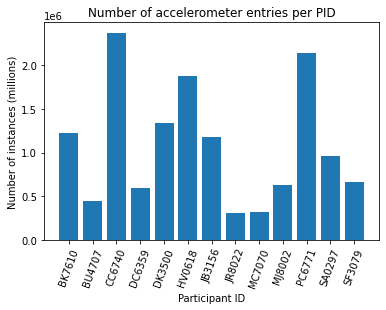

In [11]:
plt.xticks(rotation=70)
plt.xlabel('Participant ID')
plt.ylabel('Number of instances (millions)')
plt.title('Number of accelerometer entries per PID')
plt.bar(pid_instances.keys(), pid_instances.values())

We have found that the accelerometer data contains 14 million (14057567) entries and 5 columns: time, pid, x, y, z. There are no missing values. The data is a concatenation of the 13 individuals' cell phone accelerometer data. Some individuals had as few as 300k instances while others had > 2 million. This might not be an issue--the main thing we care about is whether we have enough TAC data that's both above and below 8% so that we have enough drunk/sober datapoints to train our model.

In the next step, we will need to load the TAC Data and join it to our accelerometer data. I have noticed that the dataset takes 536.3+ MB memory, manipulating the data becomes very time-consuming and cumbersome. It may be more time-efficient (for now) to join subsets of the accelerometer data to each individuals' TAC data instead. We would work with 13 smaller dataframes, rather than 1 large one.

## 2.4 Load the TAC Data<a id='2.4_Load_the_TAC_Data'></a>

In [12]:
# change directories to where raw TAC (transdermal alcohol concentration) is located.
path = 'raw_tac'
os.chdir(path)

In [13]:
# save as pandas df, each raw_TAC file for each participant, total of 13. 
# Take note that we've loaded them alphabetically, 
# so if we place them in a list, it lines up with pid_list from earlier.

pid1 = pd.read_excel('BK7610 CAM Results.xlsx', header=1)
pid2 = pd.read_excel('BU4707 CAM Results.xlsx', header=1)
pid3 = pd.read_excel('CC6740 CAM Results.xlsx', header=1)
pid4 = pd.read_excel('DC6359 CAM Results.xlsx', header=1)
pid5 = pd.read_excel('DK3500 CAM Results.xlsx', header=1)
pid6 = pd.read_excel('HV0618 CAM Results.xlsx', header=1)
pid7 = pd.read_excel('JB3156 CAM Results.xlsx', header=1)
pid8 = pd.read_excel('JR8022 CAM Results.xlsx', header=1)
pid9 = pd.read_excel('MC7070 CAM Results.xlsx', header=1)
pid10 = pd.read_excel('MJ8002 CAM Results.xlsx', header=1)
pid11 = pd.read_excel('PC6771 CAM Results.xlsx', header=1)
pid12 = pd.read_excel('SA0297 CAM Results.xlsx', header=1)
pid13 = pd.read_excel('SF3079 CAM Results.xlsx', header=1)

In [14]:
# We take a look at the first few lines of pid1.
pid1.head()

# The only lines we care about are the TAC level and the time. 
# We can get rid of the other columns.
# We can also convert the Time into Unix Timestamp to match with the accelerometer data.

,TAC Level,Unnamed: 1,Unnamed: 2,IR Voltage,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Temperature,Unnamed: 9,Unnamed: 10,Time,Unnamed: 12,Unnamed: 13,Unnamed: 14,Date,Unnamed: 16,Unnamed: 17
0,0.0,NaN,NaN,1.127,NaN,NaN,NaN,NaN,74.955,NaN,NaN,2017-05-02 10:36:54,NaN,NaN,NaN,2017-05-02 10:36:54,NaN,NaN
1,0.0,NaN,NaN,1.121,NaN,NaN,NaN,NaN,74.955,NaN,NaN,2017-05-02 11:09:57,NaN,NaN,NaN,2017-05-02 11:09:57,NaN,NaN
2,0.0,NaN,NaN,1.069,NaN,NaN,NaN,NaN,76.627,NaN,NaN,2017-05-02 11:15:27,NaN,NaN,NaN,2017-05-02 11:15:27,NaN,NaN
3,0.0,NaN,NaN,1.060,NaN,NaN,NaN,NaN,77.371,NaN,NaN,2017-05-02 11:20:57,NaN,NaN,NaN,2017-05-02 11:20:57,NaN,NaN
4,0.0,NaN,NaN,1.108,NaN,NaN,NaN,NaN,77.929,NaN,NaN,2017-05-02 11:26:26,NaN,NaN,NaN,2017-05-02 11:26:26,NaN,NaN


In [15]:
pid1.columns

Index(['TAC Level', 'Unnamed: 1', 'Unnamed: 2', 'IR Voltage', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Temperature', 'Unnamed: 9',
       'Unnamed: 10', 'Time', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14',
       'Date', 'Unnamed: 16', 'Unnamed: 17'],
      dtype='object')

In [16]:
# We select only the columns we are interested in: TAC level and the time.

def TAC_time_only(df):
    """Takes a raw_TAC file and returns only the TAC reading and the time columns."""
    df_new = df[['TAC Level', 'Time']]
    return df_new

tac1 = TAC_time_only(pid1)
tac1.head()

,TAC Level,Time
0,0.0,2017-05-02 10:36:54
1,0.0,2017-05-02 11:09:57
2,0.0,2017-05-02 11:15:27
3,0.0,2017-05-02 11:20:57
4,0.0,2017-05-02 11:26:26


In [17]:
# We use TAC_time_only() for all the raw TAC dataframes.
tac2 = TAC_time_only(pid2)
tac3 = TAC_time_only(pid3)
tac4 = TAC_time_only(pid4)
tac5 = TAC_time_only(pid5)
tac6 = TAC_time_only(pid6)
tac7 = TAC_time_only(pid7)
tac8 = TAC_time_only(pid8)
tac9 = TAC_time_only(pid9)
tac10 = TAC_time_only(pid10)
tac11 = TAC_time_only(pid11)
tac12 = TAC_time_only(pid12)
tac13 = TAC_time_only(pid13)

tac13.head()

,TAC Level,Time
0,0.0,2017-05-02 11:39:50
1,0.0,2017-05-02 12:12:15
2,0.0,2017-05-02 12:17:30
3,0.0,2017-05-02 12:22:44
4,0.0,2017-05-02 12:27:58


In [18]:
# Check to see what datatypes we have in our tac data. 
tac1.info()

# We need to convert datetime64 to Unix timestamp (int64)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   TAC Level  57 non-null     float64       
 1   Time       57 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 KB


In [19]:
# Convert all the time columns to Unix timestamp.
tac1 = TAC_time_only(pid1)

def get_unixtime(dt64):
    return dt64.astype('datetime64[s]').astype('int64')

tac1['Time'] = (get_unixtime(tac1['Time'])/1e9).astype(np.int64) #Divide by 1e9 to convert to seconds

tac1.tail()

<ipython-input-19-3c7952e3d396>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tac1['Time'] = (get_unixtime(tac1['Time'])/1e9).astype(np.int64) #Divide by 1e9 to convert to seconds


,TAC Level,Time
52,0.0,1493803087
53,0.0,1493805138
54,0.0,1493806953
55,0.0,1493808784
56,0.0,1493810599


In [20]:
tac1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TAC Level  57 non-null     float64
 1   Time       57 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 1.0 KB


In [21]:
# Use get_unixtime() for all the TAC data.

tac1 = TAC_time_only(pid1) # reset tac1 so we can easily iterate over all the tac dataframes.
TAC_list = [tac1, tac2, tac3, tac4, tac5, tac6, tac7, tac8, tac9, tac10, tac11, tac12, tac13]

for i in range(13):
    TAC_list[i]['Time'] = (get_unixtime(TAC_list[i]['Time'])/1e9).astype(np.int64) 

tac13.head()

<ipython-input-21-2a546a46fcef>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TAC_list[i]['Time'] = (get_unixtime(TAC_list[i]['Time'])/1e9).astype(np.int64)


,TAC Level,Time
0,0.0,1493725190
1,0.0,1493727135
2,0.0,1493727450
3,0.0,1493727764
4,0.0,1493728078


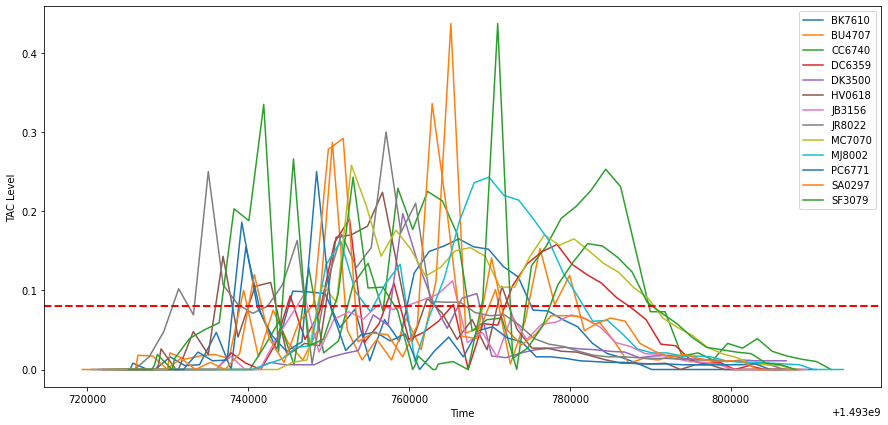

In [22]:
#Let's plot the raw TAC to see how our drinking data looks versus time.

fig, ax = plt.subplots(figsize=(15,7))

for i in range(13):
    sns.lineplot(data=TAC_list[i], x=TAC_list[i]['Time'], y=TAC_list[i]['TAC Level'], 
                 label=pid_list[i])

plt.axhline(y=0.08, linewidth=2, color='r', linestyle='--')
plt.legend(loc='upper right')
plt.show()

The transdermal alcohol content (TAC) of the 13 individuals can be seen above. The data appears noisy, and it is known that SCRAM bracelets do not have accurate TAC readings at low TAC. We should consider running a smoothing function over the data to see the results.

The red dashed line is the 8% BAC level, where one is considered legally intoxicated at or above that level. There appears to be a good number of instances above that level, which we could use to train our data.

We should look into how much of the data is at or above 8%, and how much is below, for each individual. This may be important later in deciding how we want to split our train/test data.

In [23]:
# Check to see the number of instances above or below 8% TAC for each individual.
# This is to make see if we have similar number of events in both classes and we don't have an imbalanced dataset.
# We can do what we did with the accelerometer data in the previous section.

pid_TAC_instances = {}

for i in range(13):
    pid_TAC_instances[pid_list[i]] = [(TAC_list[i]['TAC Level'].values >=0.08).sum(),
                                      (TAC_list[i]['TAC Level'].values <0.08).sum(),
                                      (TAC_list[i]['TAC Level'].count())]
    
pid_TAC_instances

{'BK7610': [12, 45, 57],
 'BU4707': [8, 47, 55],
 'CC6740': [16, 40, 56],
 'DC6359': [13, 42, 55],
 'DK3500': [5, 46, 51],
 'HV0618': [10, 44, 54],
 'JB3156': [6, 49, 55],
 'JR8022': [17, 30, 47],
 'MC7070': [23, 33, 56],
 'MJ8002': [15, 44, 59],
 'PC6771': [2, 54, 56],
 'SA0297': [7, 51, 58],
 'SF3079': [17, 37, 54]}

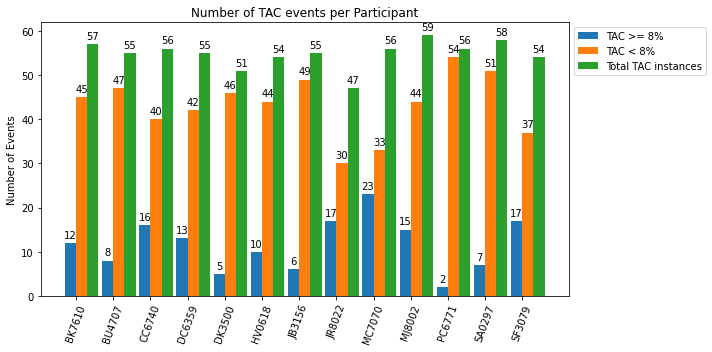

In [24]:
# Here we graph bar plots of the data.
# Use as reference: 
# https://matplotlib.org/3.3.2/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

# make empty lists
labels = pid_list
above_8 = []
below_8 = []
total =[]

# populate those lists from pid_TAC_instances dictionary
for i in range(13):
    key = pid_list[i]
    above_8.append(pid_TAC_instances[key][0])
    below_8.append(pid_TAC_instances[key][1])
    total.append(pid_TAC_instances[key][2])

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, above_8, width, label='TAC >= 8%')
rects2 = ax.bar(x + width/2, below_8, width, label='TAC < 8%')
rects3 = ax.bar(x + 1.5*width, total, width, label='Total TAC instances')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Events')
ax.set_title('Number of TAC events per Participant')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.xticks(rotation=70)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

From a glance, we can tell that each participant had roughly the same number of total instances recorded in their TAC data. All participants had more instances where TAC < 8%. We may need to be wary of this when we split our train/test data. We should also keep in mind that these numbers may change slightly after we smooth our data.

## 2.5 Exploring the Data<a id='2.5_Exploring_the_Data'></a>

Here let's explore how each individuals' accelerometer data varies with their TAC data, and also the effects of various smoothing methods.

### 2.5.1 Combining Accelerometer and TAC data<a id='2.5.1_Combining_Accelerometer_and_TAC_data'></a>

In [25]:
# Note that the accelerometer data includes milliseconds in the time column. 
# We could convert acc data to seconds by dividing by 1000, but that gives us float64 while the TAC time column is int64.
# Instead we could multiple TAC time column by 1000 and keep the type as int64.

TAC_list_copy=[]

for i in range(13):
    TAC_list_copy.append(TAC_list[i].copy())
    TAC_list_copy[i]['Time'] = (TAC_list_copy[i]['Time']*1000)

TAC_list_copy[0].head()

,TAC Level,Time
0,0.0,1493721414000
1,0.0,1493723397000
2,0.0,1493723727000
3,0.0,1493724057000
4,0.0,1493724386000


In [26]:
TAC_list[0].head()
# We can see our original TAC_list is unaffected.

,TAC Level,Time
0,0.0,1493721414
1,0.0,1493723397
2,0.0,1493723727
3,0.0,1493724057
4,0.0,1493724386


In [27]:
# Let's combine each participant's accelerometer data and TAC data into a new dataframe.

def merge_acc_TAC(acc_df, index=0):
    """Merge acc_df and TAC_df on timestamp column.
    Index refers to the index of the participant in the participant list, pid_list."""
    
    TAC_df = TAC_list_copy[index] #select the appropriate TAC df
    TAC_renamed = TAC_df.rename(columns={"Time": "time"}) #rename the "time" column so we can merge on it
    
    acc_individual = acc_df[acc_df.pid == pid_list[index]] #select appropriate subset of accelerometer data
    
    combined = pd.merge(acc_individual, TAC_renamed, how='outer', on='time') #merge the two df's
    
    return combined

pid1_acc_TAC = merge_acc_TAC(acc, index=0)
pid1_acc_TAC.sort_values('time')

,time,pid,x,y,z,TAC Level
1225727,1493721414000,NaN,NaN,NaN,NaN,0.0
1225728,1493723397000,NaN,NaN,NaN,NaN,0.0
1225729,1493723727000,NaN,NaN,NaN,NaN,0.0
1225730,1493724057000,NaN,NaN,NaN,NaN,0.0
1225731,1493724386000,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...
1225777,1493803087000,NaN,NaN,NaN,NaN,0.0
1225778,1493805138000,NaN,NaN,NaN,NaN,0.0
1225779,1493806953000,NaN,NaN,NaN,NaN,0.0
1225780,1493808784000,NaN,NaN,NaN,NaN,0.0


In [28]:
pid1_acc_TAC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1225782 entries, 0 to 1225781
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   time       1225782 non-null  int64  
 1   pid        1225727 non-null  object 
 2   x          1225727 non-null  float64
 3   y          1225727 non-null  float64
 4   z          1225727 non-null  float64
 5   TAC Level  57 non-null       float64
dtypes: float64(4), int64(1), object(1)
memory usage: 65.5+ MB


We did an outer merge, so it should be expected that our data would be full of NaNs. It also appears that the TAC data begins before the accelerometer data for Participant 1, and continues after accelerometer data ends. Before we decide to delete the portions of the TAC data that do not have corresponding accelerometer data, we should keep in mind that there is generally a 45-minute to 2-hour lag between alcohol ingestion and transdermal alcohol readings (we go into more detail in the summary section below). We will need to decide how much to shift our TAC data (subtracting anywhere from 45-minute to 2-hours from the time column) and then match that to the accelerometer axis.

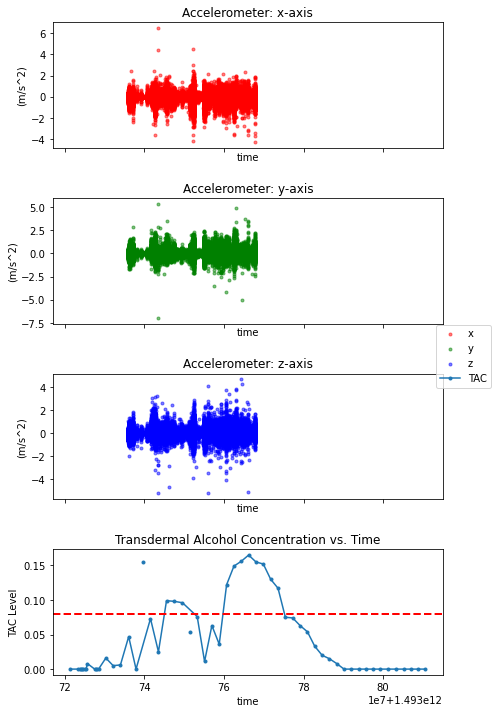

In [29]:
# Plot the accelerometer and TAC data.

def plot_acc_TAC(df):
    """This function accepts a dataframe that has x, y, z, and TAC columns; and unix time column.
    It returns a graph that has the x, y, z subplots and TAC line plot as a 4-row subplot."""

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(7,12), sharex=True)

    ax1.scatter(df.time, df.x, label='x', marker='.', alpha=0.5, color='r')
    ax2.scatter(df.time, df.y, label='y', marker='.', alpha=0.5, color='g')
    ax3.scatter(df.time, df.z, label='z', marker='.', alpha=0.5, color='b')
    ax4.plot(df.time, df['TAC Level'], label='TAC', linestyle='-', marker='.')

    ax4.axhline(y=0.08, linewidth=2, color='r', linestyle='--')

    fig.legend(loc='right')
    ax1.set_xlabel('time')
    ax2.set_xlabel('time')
    ax3.set_xlabel('time')
    ax4.set_xlabel('time')

    ax1.set_ylabel('(m/s^2)')
    ax2.set_ylabel('(m/s^2)')
    ax3.set_ylabel('(m/s^2)')
    ax4.set_ylabel('TAC Level')

    ax1.set_title('Accelerometer: x-axis')
    ax2.set_title('Accelerometer: y-axis')
    ax3.set_title('Accelerometer: z-axis')
    ax4.set_title('Transdermal Alcohol Concentration vs. Time')

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

    plt.show()

    
# Plot the accelerometer and TAC data for Participant 1.
plot_acc_TAC(pid1_acc_TAC)

It looks like we have a far smaller time frame for the accelerometer data than the TAC data! But this is only the first participant. We should check briefly for all 13 participants. Furthermore, we may need to shift the TAC data backwards in time to overlap with the actual moment of intoxication in the accelerometer data, due to the time lag between alcohol consumption and the evaporation of alcohol through the skin from the bloodstream.

We also notice that the line plot skipped 2 of the points in the TAC data. This may be due to the many NaN values in the df. When we try smoothing methods on the TAC data, we should manipulate the dataframs which contain just the TAC data (i.e. the df's in TAC_list).

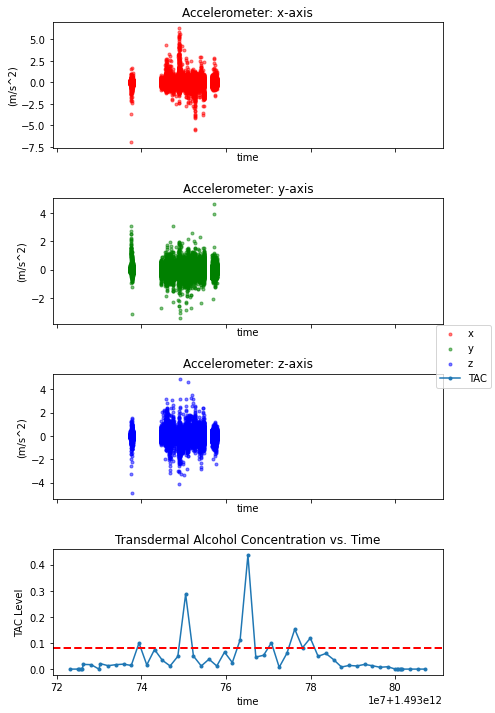

In [30]:
# Use functions merge_acc_TAC(acc_df, index=0) and plot_acc_TAC(df)
# to plot the accelerometer data and TAC data of the remaining 12 participants. 

# participant 2
pid2_acc_TAC = merge_acc_TAC(acc, index=1)
pid2_acc_TAC.sort_values('time')
plot_acc_TAC(pid2_acc_TAC)

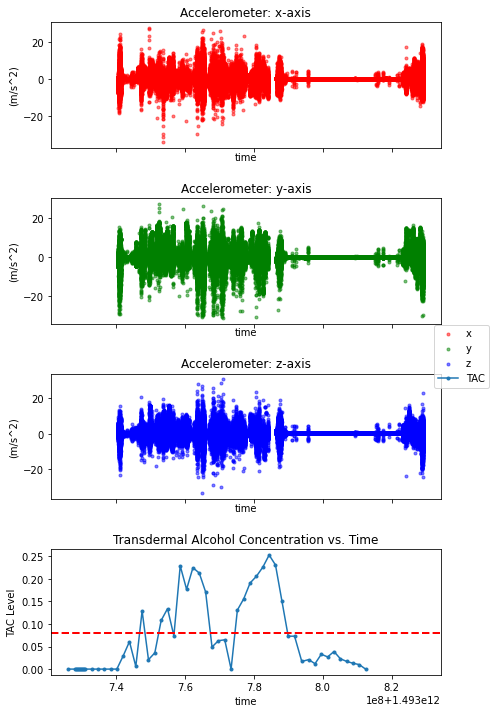

In [31]:
# participant 3
pid3_acc_TAC = merge_acc_TAC(acc, index=2)
pid3_acc_TAC.sort_values('time')
plot_acc_TAC(pid3_acc_TAC)

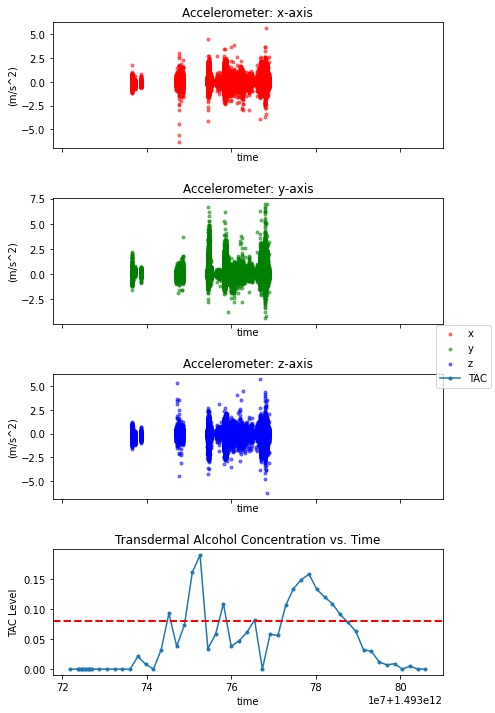

In [32]:
# participant 4
pid4_acc_TAC = merge_acc_TAC(acc, index=3)
pid4_acc_TAC.sort_values('time')
plot_acc_TAC(pid4_acc_TAC)

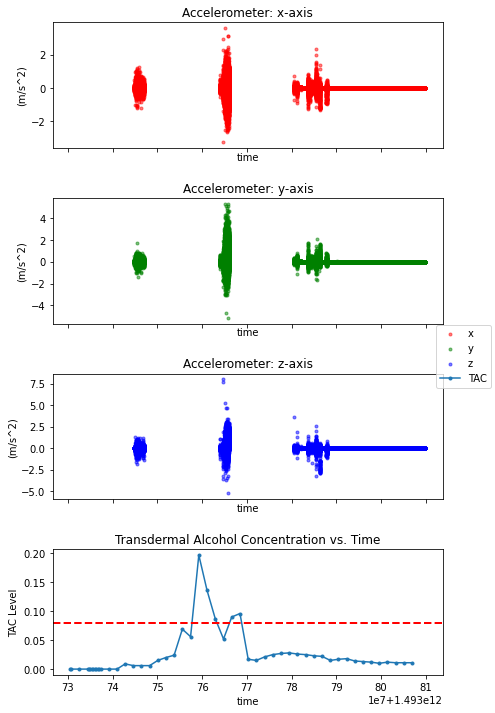

In [33]:
# participant 5
pid5_acc_TAC = merge_acc_TAC(acc, index=4)
pid5_acc_TAC.sort_values('time')
plot_acc_TAC(pid5_acc_TAC)

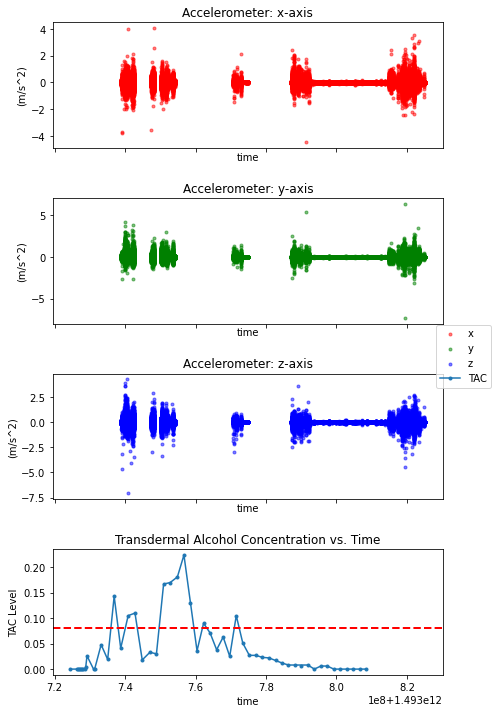

In [34]:
# participant 6
pid6_acc_TAC = merge_acc_TAC(acc, index=5)
pid6_acc_TAC.sort_values('time')
plot_acc_TAC(pid6_acc_TAC)

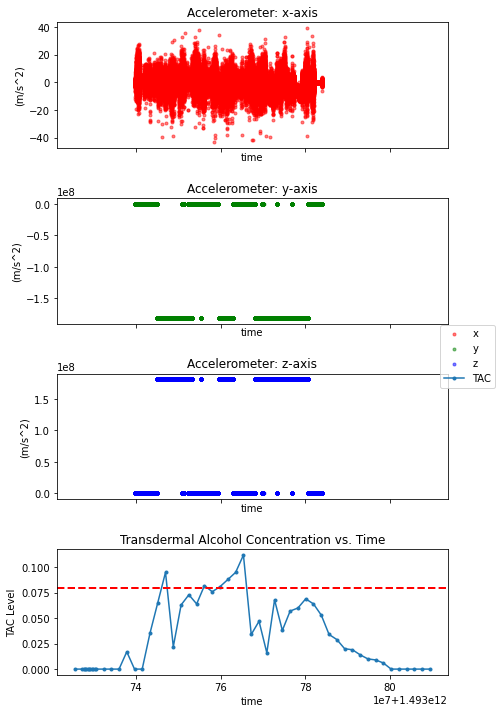

In [35]:
# participant 7
pid7_acc_TAC = merge_acc_TAC(acc, index=6)
pid7_acc_TAC.sort_values('time')
plot_acc_TAC(pid7_acc_TAC)

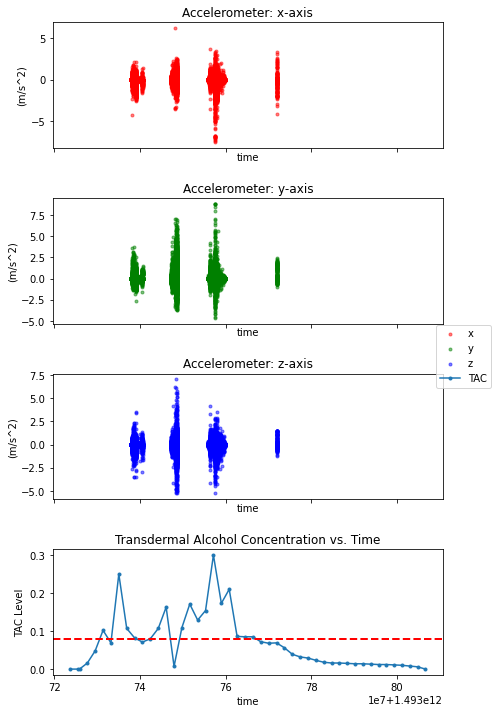

In [36]:
# participant 8
pid8_acc_TAC = merge_acc_TAC(acc, index=7)
pid8_acc_TAC.sort_values('time')
plot_acc_TAC(pid8_acc_TAC)

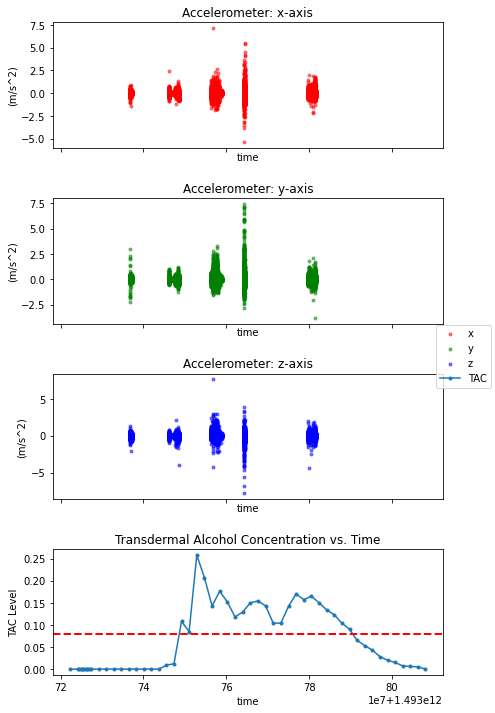

In [37]:
# participant 9
pid9_acc_TAC = merge_acc_TAC(acc, index=8)
pid9_acc_TAC.sort_values('time')
plot_acc_TAC(pid9_acc_TAC)

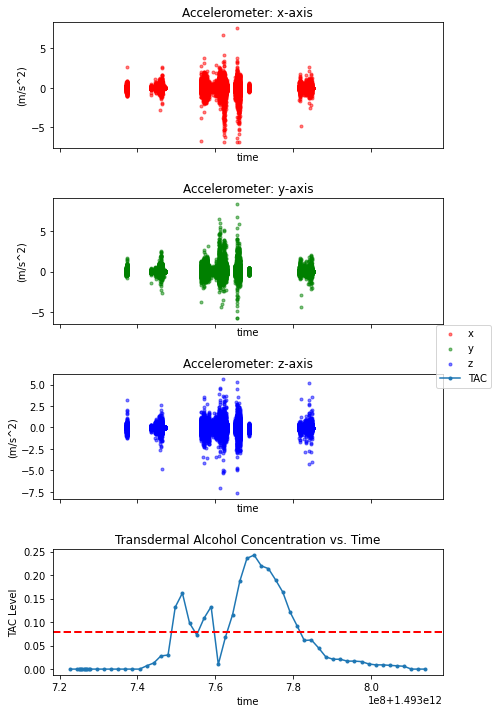

In [38]:
# participant 10
pid10_acc_TAC = merge_acc_TAC(acc, index=9)
pid10_acc_TAC.sort_values('time')
plot_acc_TAC(pid10_acc_TAC)

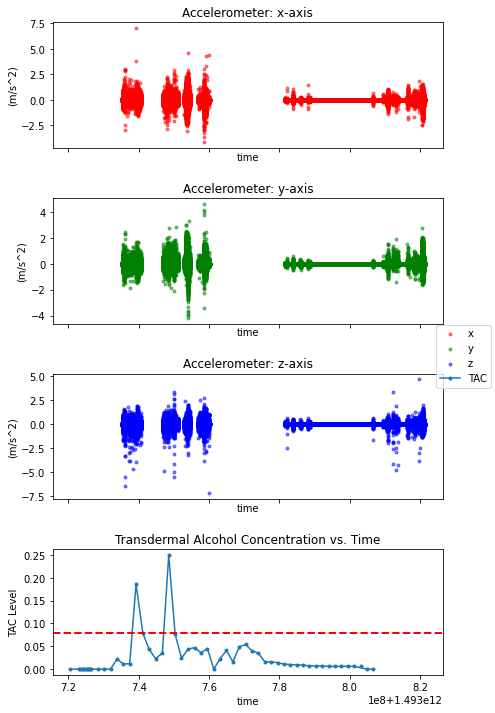

In [39]:
# participant 11
pid11_acc_TAC = merge_acc_TAC(acc, index=10)
pid11_acc_TAC.sort_values('time')
plot_acc_TAC(pid11_acc_TAC)

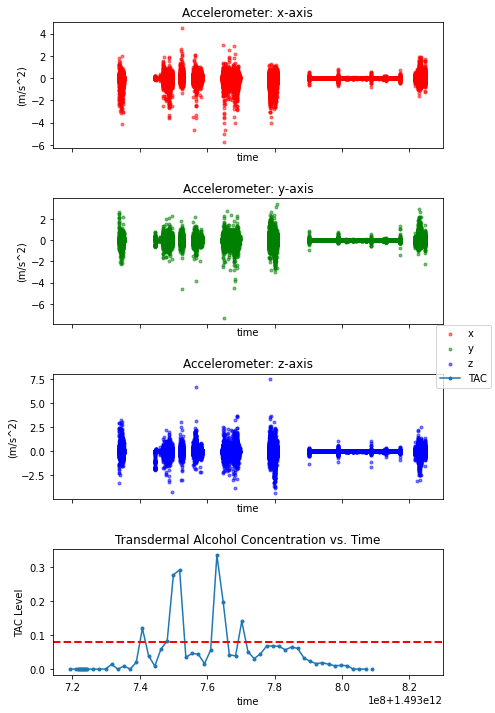

In [40]:
# participant 12
pid12_acc_TAC = merge_acc_TAC(acc, index=11)
pid12_acc_TAC.sort_values('time')
plot_acc_TAC(pid12_acc_TAC)

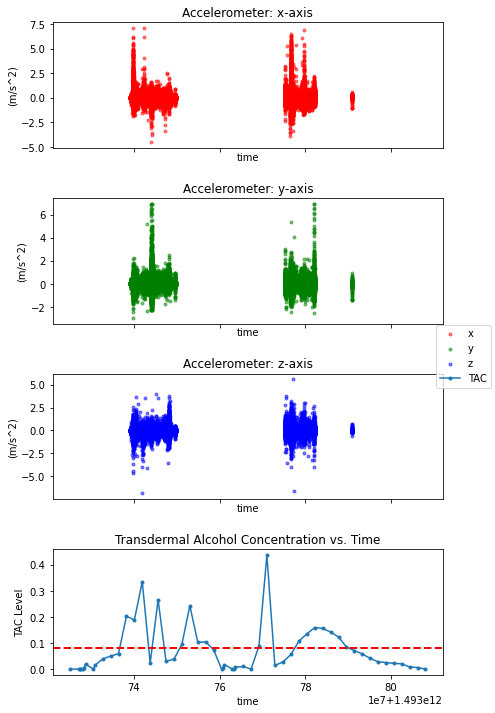

In [41]:
# participant 13
pid13_acc_TAC = merge_acc_TAC(acc, index=12)
pid13_acc_TAC.sort_values('time')
plot_acc_TAC(pid13_acc_TAC)

There are a lot of gaps in the accelerometer data for various participants. We should check to see we did not skip over any data in our accelerometer dataframe, "acc".

In [42]:
counter = 0

for i in range(13):
    counter = counter + len(acc[acc.pid == pid_list[i]])

counter

14057565

In [43]:
counter == len(acc)

True

We added the length of each subset of the accelerometer data, selected by Participant ID (pid). The sum of the lengths of all those subset dataframes equals the length of the original acc dataframe. This means our gaps in data was not due to any datapoints having been incorrectly recorded or pid having been incorrectly written. The gaps in the accelerometer data are real missing data points.

In [44]:
# This code block is for plotting just the accelerometer data (x, y, and z axes) as vertical subplots.
# This is in case you want to check what the accelerometer data looks like, without the TAC data.
# Un-comment the code to run it. Change the number in "pid_list[]" for different participants.

#df = acc[acc.pid == pid_list[6]]
#fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(7,12), sharex=True)
#ax1.scatter(df.time, df.x, label='x', marker='.', alpha=0.5, color='r')
#ax2.scatter(df.time, df.y, label='y', marker='.', alpha=0.5, color='g')
#ax3.scatter(df.time, df.z, label='z', marker='.', alpha=0.5, color='b')
#plt.show()

Recorded here are some observations noted for each participant (here referred to as pid).

__Notes about pid1:__ The accelerometer data spans for less than half the time of the TAC data.

__Notes about pid2:__ The gap in accelerometer data could possibly be explained by a lack of movement (like setting down the cell phone on a table). Though if this were the case, we should expect to see 0 values in the x,y,z axes. It is quite possible we just have missing data.

__Notes about pid3:__ The accelerometer data and TAC data are actually similar in timespan!

__Notes about pid4, pid5, pid6:__ Gaps in acc data. Similar to pid2.

__Notes about pid7:__ The y- and z-axes are invert of each other, while the x-axes varies randomly like the other pid's. It is possible this participant's phone was not in their pocket or purse, but in some sort of backpack or bag that was stable in the y- and z-axes. 

__Notes about pid8, pid9, pid10, pid11, pid12:__ Multiple gaps in acc data. Similar to pid5 and pid6.

__Notes about pid13:__ One large gap in acc data. Similar to pid5 and other participants with missing acc data.

Upon visual inspection, only pid1, pid3, and pid7 do not have large gaps of accelerometer data. Looking at the phonetype CSV file (below), we see that pid3 and pid7 use Android phones while the others use iPhones. 

I could not find any information online about missing values in accelerometer data for iPhones, but I believe it's quite possible that the iPhone may have stopped recording accelerometer data whenever the iPhone was no longer in motion. If this is the case, we may want to impute the missing values with zeroes.

In [45]:
# load and inspect the phone_types CSV file. 

os.chdir('..')
phone_type = pd.read_csv('phone_types.csv')
phone_type

,pid,phonetype
0,BK7610,iPhone
1,BU4707,iPhone
2,CC6740,Android
3,DC6359,iPhone
4,DK3500,iPhone
5,HV0618,iPhone
6,JB3156,Android
7,JR8022,iPhone
8,MC7070,iPhone
9,MJ8002,iPhone


We now have our raw accelerometer data and raw TAC data grouped by participant, and merged as individual dataframes. Although there are NaN values, we may want to hold off from imputing values (like zero) or deleting segments of the data before we have shifted our TAC data. For now, let's save each dataframe into a CSV file in our "data" folder.

In [46]:
# Exit raw_data directory and change to data directory.

os.chdir('..')
path='data'
os.chdir(path)

In [47]:
# Save each pid##_acc_TAC df into a CSV file.

pid1_acc_TAC.to_csv('pid1_acc_TAC.csv')
pid2_acc_TAC.to_csv('pid2_acc_TAC.csv')
pid3_acc_TAC.to_csv('pid3_acc_TAC.csv')
pid4_acc_TAC.to_csv('pid4_acc_TAC.csv')
pid5_acc_TAC.to_csv('pid5_acc_TAC.csv')
pid6_acc_TAC.to_csv('pid6_acc_TAC.csv')
pid7_acc_TAC.to_csv('pid7_acc_TAC.csv')
pid8_acc_TAC.to_csv('pid8_acc_TAC.csv')
pid9_acc_TAC.to_csv('pid9_acc_TAC.csv')
pid10_acc_TAC.to_csv('pid10_acc_TAC.csv')
pid11_acc_TAC.to_csv('pid11_acc_TAC.csv')
pid12_acc_TAC.to_csv('pid12_acc_TAC.csv')
pid13_acc_TAC.to_csv('pid13_acc_TAC.csv')

### 2.5.2 Smoothing the raw TAC data<a id='2.5.2_Smoothing_the_raw_TAC_data'></a>

As we saw in section 2.4, when we loaded the TAC data and visualized it, it was quite noisy.

For the TAC data, it is important to think of different ways to do outlier detection and smoothing. We can try various methods in pandas that allows us to implement a moving average as a smoothing technique. 

Below we attempt the following smoothing techniques:
* pandas rolling() method for simple moving average smoothing. 
  * try out different window sizes.
* pandas.core.resample.Resampler.interpolate
  * try out different methods to interpolate: quadratic, cubic, polynomial, spline. Note: for polynomial and spline, also specify "order". 

Note: we do not want to use weighted moving averages; there is no reason to put more emphasis on more recent data. We treat all of the TAC data as equally valid, as they measure real-time transdermal alcohol concentrations.

Note: TAC data was collected every 30 minutes. A window size of 2 is equivalent to a 1-hour window.

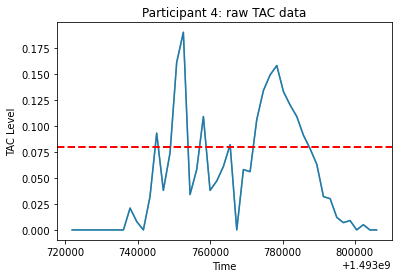

In [48]:
# Let's look at participant 4.

def plot_TAC(df, title=''):
    """Plots TAC dataframe and overlays it on tac4 df."""
    fig, ax = plt.subplots()
    sns.lineplot(data=tac4, x=tac4['Time'], y=tac4['TAC Level'], color='g', alpha=0.5)
    sns.lineplot(data=df, x=df['Time'], y=df['TAC Level'])
    plt.axhline(y=0.08, linewidth=2, color='r', linestyle='--')
    plt.title(title)
    plt.show()

plot_TAC(tac4, title='Participant 4: raw TAC data')

#### 2.5.2.1 Rolling Average<a id='2.5.2.1_Rolling_Average'></a>

Use the pandas rolling() method with varying window sizes.

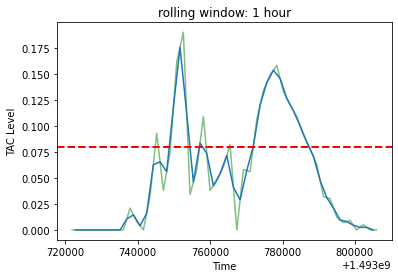

In [49]:
# Rolling average, window size = 2 (1 hour)
tac4_window_2 = tac4.rolling(2, center=True).mean()
plot_TAC(tac4_window_2, title='rolling window: 1 hour')

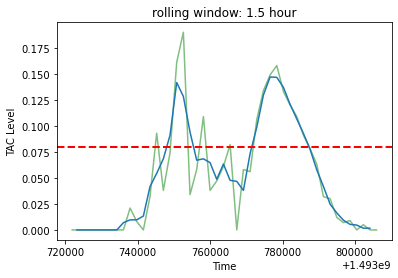

In [50]:
# Rolling average, window size = 3 (1.5 hour)
tac4_window_3 = tac4.rolling(3, center=True).mean()
plot_TAC(tac4_window_3, title='rolling window: 1.5 hour')

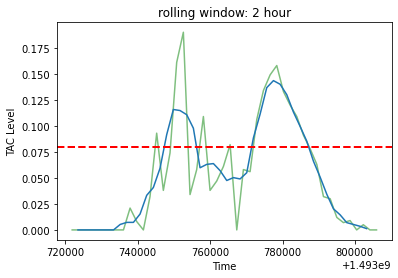

In [51]:
# Rolling average, window size = 4 (2 hour)
tac4_window_4 = tac4.rolling(4, center=True).mean()
plot_TAC(tac4_window_4, title='rolling window: 2 hour')

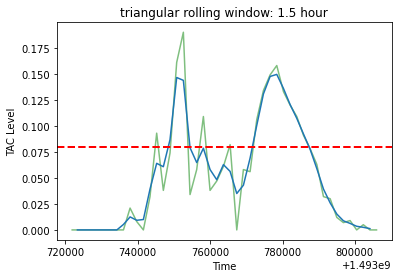

In [52]:
# Rolling average, window size = 3 (1.5 hour), triangular moving average (places more weight on adjacent points)
tac4_window_3_tri = tac4.rolling(3, center=True, win_type='triang').mean()
plot_TAC(tac4_window_3_tri, title='triangular rolling window: 1.5 hour')

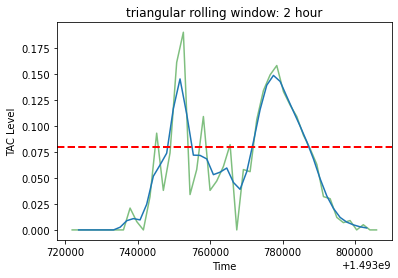

In [53]:
# Rolling average, window size = 4 (2 hour), triangular moving average (places more weight on adjacent points)
tac4_window_4_tri = tac4.rolling(4, center=True, win_type='triang').mean()
plot_TAC(tac4_window_4_tri, title='triangular rolling window: 2 hour')

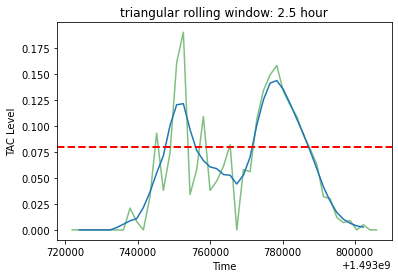

In [54]:
# Rolling average, window size = 5 (2.5 hour), triangular moving average (places more weight on adjacent points)
tac4_window_5_tri = tac4.rolling(5, center=True, win_type='triang').mean()
plot_TAC(tac4_window_5_tri, title='triangular rolling window: 2.5 hour')

From a quick glance, a rolling window of 1 hour seems to be insufficient in smoothing (there are still many jagged features). 

A rolling window of 1.5 or 2 hours appears more promising, with a triangular moving average with 2-hour window maintaining more features than its regular rolling window counterpart. 

A rolling window of 2.5 hours appears to have lost most of its features, and is too smooth.

#### 2.5.2.2 Interpolation<a id='2.5.2.2_Interpolation'></a>

Use pandas.core.resample.Resampler.interpolate(). Try out different methods to interpolate: quadratic, cubic, polynomial, spline. Note: for polynomial and spline, also specify "order".

In [55]:
# Create a dataframe with all the timepoints in tac4 data, with the time column interpolated with step size 1.

start_time = tac4.Time.min()
end_time = tac4.Time.max()
time_interpolate = np.arange(start_time, end_time+1, step=1)

tac4_interpolate_time = pd.DataFrame(data={'Time':time_interpolate})
tac4_interpolate_raw = pd.merge(tac4_interpolate_time, tac4, how='left', on='Time')
tac4_interpolate_raw.info()

# We see that the merge was successful, all the missing TAC Level data are null values.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84025 entries, 0 to 84024
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Time       84025 non-null  int64  
 1   TAC Level  55 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.9 MB


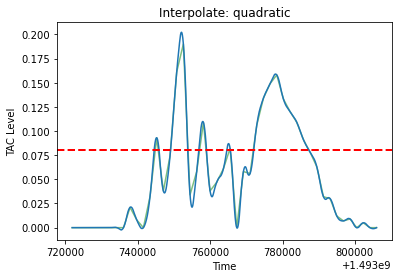

In [56]:
# Interpolate, method = quadratic
tac4_interpolate_quad = tac4_interpolate_raw.interpolate(method='quadratic')
plot_TAC(tac4_interpolate_quad, title='Interpolate: quadratic')

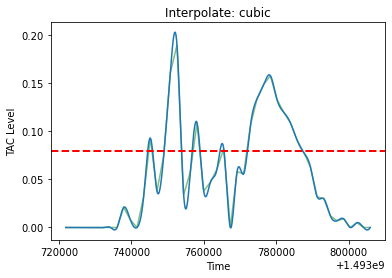

In [57]:
# Interpolate, method = cubic
tac4_interpolate_cubic = tac4_interpolate_raw.interpolate(method='cubic')
plot_TAC(tac4_interpolate_cubic, title='Interpolate: cubic')

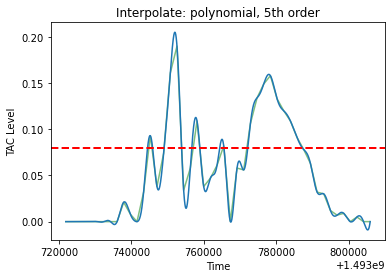

In [58]:
# Interpolate, method = polynomial, order = 5
tac4_interpolate_poly = tac4_interpolate_raw.interpolate(method='polynomial', order=5)
plot_TAC(tac4_interpolate_poly, title='Interpolate: polynomial, 5th order')

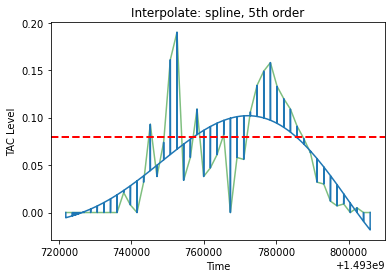

In [59]:
# Interpolate, method = spline, order = 5
tac4_interpolate_spline = tac4_interpolate_raw.interpolate(method='spline', order=5)
plot_TAC(tac4_interpolate_spline, title='Interpolate: spline, 5th order')

From a visual inspection of the interpolated TAC data, the quadratic and cubic functions look promising. The 5th order polynomial and spline appear to add or lose features of the graph, respectively.

## 2.6 Summary and Next Steps<a id='2.6_Summary_and_Next_Steps'></a>

__Summary of the Notebook:__

* We confirmed our raw data had no NaN values in either the accelerometer data or TAC data. 
* We removed 2 accelerometer datapoints with timestamp 0. 
* We found that some participants (e.g. pid3, pid11) had more accelerometer entries than other participants, while certain others had particularly low counts of accelerometer entries (e.g. pid8, pid9). This could be explained by the fact that participants with iPhones were found to have gaps in their accelerometer data. When plotted against the TAC data, there were significant lapses of data. This may be due to lack of movement by the participants (e.g. setting their phone or bag down when sitting at a bar), which may have led to the smartphone terminated data collection.
* We extracted the TAC Level and Time columns from the raw TAC data, and converted the Time column to a Unix Timestamp, making it comparable to the accelerometer data (though the accelerometer data includes 3 additional units, for milliseconds).
* We found that there were much more instances where TAC < 8% than TAC >= 8%. This may be partially due to the low TAC levels at the beginning and end of the datasets. Our resulting dataset after we shift and clean the TAC data may look very different. Regardless, we should still keep this in mind in case we do need to deal with an imbalanced dataset.
* We combined our accelerometer and TAC data and saved each individual partipant's combined dataframe as a CSV file to use in our later steps. We kept the NaN values in the exported CSV, which gives us flexiblity in our next steps in deciding whether  to interpolate, do a running average smoothing, etc., and also how we want to shift the data.
* While trying different smoothing methods on the raw TAC data, we found that a rolling window of 1.5 or 2 hours and interpolating with quadratic or cubic methods are most promising of the methods we tried.

__Next Steps:__ 

Using our exported CSV data files, we should plan to shift the TAC data (subtract the lag for TAC detection), and then either interpolate the data, do a running average, or do a combination of both.

After this is done, we should also crop some of the data that is missing accelerometer entries. Even if we were to impute the missing values with zeroes, it would not be useable for our machine learning model (the accelerometer x, y, and z column data are the independent variables, and the TAC values is the dependent variable).

It would be worth looking into a systematic method to optimize these steps (i.e. a systematic method of determining how large of a shift in the TAC data provides the best estimate, which smoothing methods are most suitable, etc.)

After these final manipulations, our data would be ready to train a machine learning algorithm.

__Notes about lag:__

Several papers differ about how much to of a delay there is between alcohol entering the blood stream and when it becomes detectable on the skin. Possible lags may be 45-minutes, 82.5-minutes, 120-minutes

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0185238
According to the manufacturer there is an approximate 45-minute lag between alcohol entering the blood stream and the SCRAM device reporting that it observes that alcohol through sweat. Due to this lag, all TAC readings were shifted 45 minutes forward in time. This enables the comparison of reported drinking activity with changes in TAC. Though discrepancies may exist based on individual differences in skin thickness for instance, we believe 45 minutes is enough to account for the lag in metabolizing.

https://academic.oup.com/alcalc/article/52/1/35/2605771
The time lag between the times-to-peak TAC and the times-to-peak BrAC averaged (in minutes; M (SD)) for one to five beers, respectively, as follows: 82.5 (41.2), 119.8 (46.0), 131.2 (56.6), 153.6 (71.0) and 162.0 (60.7).

https://www.scramsystems.com/wp-content/uploads/2020/06/evaluating-transdermal-alcohol-measuring-devices.pdf
There is a commonly reported 2-hour lag between a peak BAC and a peak TAC under normal
circumstances. This lag has been described in the peer-reviewed research literature and in the
materials from the private companies. The delay likely represents transit time of ethanol from body
core out to the skin surface. On the descending limb of a BAC curve, the TAC curve usually lags
behind the BAC curve more so, such that the absorption and elimination curves are asymmetrical. 

http://ceur-ws.org/Vol-2429/paper6.pdf
subtracted 45 minutes from each TAC reading to obtain readings indicative of real-time intoxication (Note: same authors as the first paper listed above)